# [Unit 16 附錄A] MNIST 手寫數字辨識實戰 – CNN 基礎入門

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**教材定位**：選讀附錄，建議在 Unit16 主課程前閱讀

**本附錄目標**：
1.  **建立 CNN 模型**：使用 TensorFlow/Keras 建立卷積神經網路 (Convolutional Neural Network)。
2.  **影像前處理**：了解影像資料的正規化 (Normalization) 與維度調整 (Reshape)。
3.  **模型訓練與評估**：觀察 Accuracy 與 Loss 的學習曲線，並討論過擬合現象。
4.  **結果視覺化**：直觀地查看模型對手寫數字的辨識結果。

**資料集介紹**：
MNIST 手寫數字資料集（0–9），包含 60,000 張訓練影像與 10,000 張測試影像。
這在化工領域可類比為：
-   產品外觀檢測（瑕疵辨識）。
-   顯微影像中的顆粒或結晶型態分類。

**學習路徑**：
- **本附錄 (MNIST)**: CNN 基礎概念與實作
- **附錄B (Cats vs Dogs)**: 遷移學習實戰
- **Unit17 (NEU 鋼材缺陷)**: 工業影像檢測完整案例

In [ ]:
# 匯入必要的套件
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path

# 設定 Matplotlib 中文字體（解決中文顯示問題）
import matplotlib
#matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
#print("✓ Matplotlib 中文字體已設定")

# ========================================
# Part_4 本地化路徑設定
# ========================================
# 使用 Part_4 本地 outputs 資料夾（不再依賴全域 Jupyter_Scripts）
NOTEBOOK_DIR = Path.cwd()
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / 'P4_Unit16_MNIST_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook 目錄: {NOTEBOOK_DIR}")
print(f"✓ 輸出目錄: {OUTPUT_DIR}")

# 檢查 GPU 狀態
print(f"\nTensorFlow Version: {tf.__version__}")

# [Windows 環境錯誤排除指南]
# 如果出現 "Could not locate zlibwapi.dll" 錯誤：
# 原因：NVIDIA cuDNN 在 Windows 上依賴 zlibwapi.dll，但 CUDA 安裝包通常未包含此檔案。
# 解決方法：
# 1. 下載 zlib123dllx64.zip (http://www.winimage.com/zLibDll/zlib123dllx64.zip)
# 2. 解壓縮後，找到 zlibwapi.dll。
# 3. 將該檔案複製到 CUDA 的 bin 資料夾中 
#    (預設路徑通常為：C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.x\bin)
# 或者 C:\Users\你的使用者名稱\miniconda3\envs\你的環境\Library\bin
# 4. 重新啟動 Jupyter Kernel 即可解決。

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    # 啟用記憶體增長，避免 OOM
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")
    print("  若有 NVIDIA 顯卡，請參考上方說明檢查 zlibwapi.dll 是否安裝正確。")

print("\n" + "="*60)
print("環境設定完成! MNIST 資料集將自動下載")
print("="*60)

✓ Matplotlib 中文字體已設定

✓ Notebook 目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
✓ 輸出目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_MNIST_Results

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）

環境設定完成! MNIST 資料集將自動下載


---
## 1. 資料載入與前處理 (Data Loading & Preprocessing)

我們使用 Keras 內建的 MNIST 資料集。
影像資料通常是 0~255 的整數，為了讓神經網路更容易收斂，我們需要將其正規化到 0~1 之間。
此外，CNN 的輸入通常需要包含「通道數 (Channel)」，因此我們需要將 (28, 28) 的影像 reshape 成 (28, 28, 1)。

In [2]:
# 載入 MNIST 資料集
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(f"原始訓練集形狀: {train_images.shape}")
print(f"原始測試集形狀: {test_images.shape}")

# 正規化 (Normalization): 0-255 -> 0-1
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Reshape: (28, 28) -> (28, 28, 1) 以符合 CNN 輸入格式 (Height, Width, Channels)
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

print("前處理後訓練集形狀:", train_images.shape)

原始訓練集形狀: (60000, 28, 28)
原始測試集形狀: (10000, 28, 28)
前處理後訓練集形狀: (60000, 28, 28, 1)


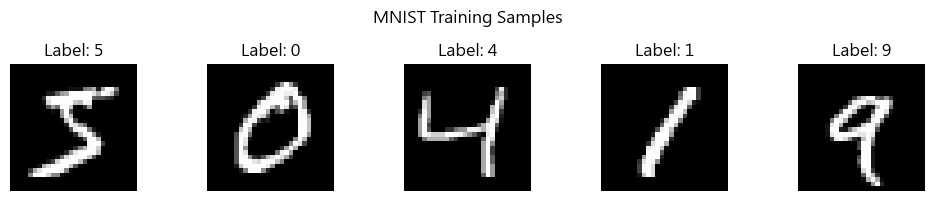

In [3]:
# 視覺化前 5 張訓練影像
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {train_labels[i]}")
    plt.axis("off")
plt.suptitle("MNIST Training Samples")
plt.tight_layout()
plt.show()

---
## 2. 建立 CNN 模型 (Build CNN Model)

我們將建立一個簡單的卷積神經網路，包含：
1.  **特徵提取層 (Feature Extraction)**：
    -   `Conv2D`：卷積層，負責提取影像特徵（如邊緣、紋理）。
    -   `MaxPooling2D`：池化層，負責降低維度並保留重要特徵。
2.  **分類層 (Classification Head)**：
    -   `Flatten`：將二維特徵圖展平為一維向量。
    -   `Dense`：全連接層，負責最後的分類決策。

In [4]:
model = models.Sequential()

# --- 特徵提取層 ---
# 第一層卷積：32 個 3x3 的濾波器
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# 第二層卷積：64 個 3x3 的濾波器
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

# 第三層卷積
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

# --- 分類層 ---
model.add(layers.Flatten()) # 展平
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax")) # 輸出 10 個類別的機率

# 顯示模型架構
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

---
## 3. 模型訓練 (Training)

我們使用 `adam` 優化器與 `sparse_categorical_crossentropy` 損失函數。
訓練過程中，我們會保留 10% 的資料作為驗證集 (Validation Set)，用來監控模型是否過擬合。

In [5]:
# 編譯模型
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# 設定訓練參數
epochs = 5
batch_size = 64

print(f"開始訓練模型 ({epochs} epochs)...")
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1, # 使用 10% 訓練資料做驗證
    verbose=1,
)
print("訓練完成！")

開始訓練模型 (5 epochs)...
Epoch 1/5
844/844 [==============================] - 5s 5ms/step - loss: 0.1972 - accuracy: 0.9406 - val_loss: 0.0613 - val_accuracy: 0.9805
Epoch 2/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0521 - accuracy: 0.9836 - val_loss: 0.0439 - val_accuracy: 0.9873
Epoch 3/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0374 - accuracy: 0.9886 - val_loss: 0.0363 - val_accuracy: 0.9887
Epoch 4/5
844/844 [==============================] - 4s 4ms/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0326 - val_accuracy: 0.9913
Epoch 5/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0398 - val_accuracy: 0.9902
訓練完成！


---
## 4. 學習曲線 (Learning Curves)

觀察 Accuracy 與 Loss 隨 Epoch 的變化，可以幫助我們判斷模型訓練狀況。
-   **正常**：Training 與 Validation 的 Accuracy 同步上升，Loss 同步下降。
-   **過擬合 (Overfitting)**：Training Accuracy 很高，但 Validation Accuracy 卡住甚至下降。

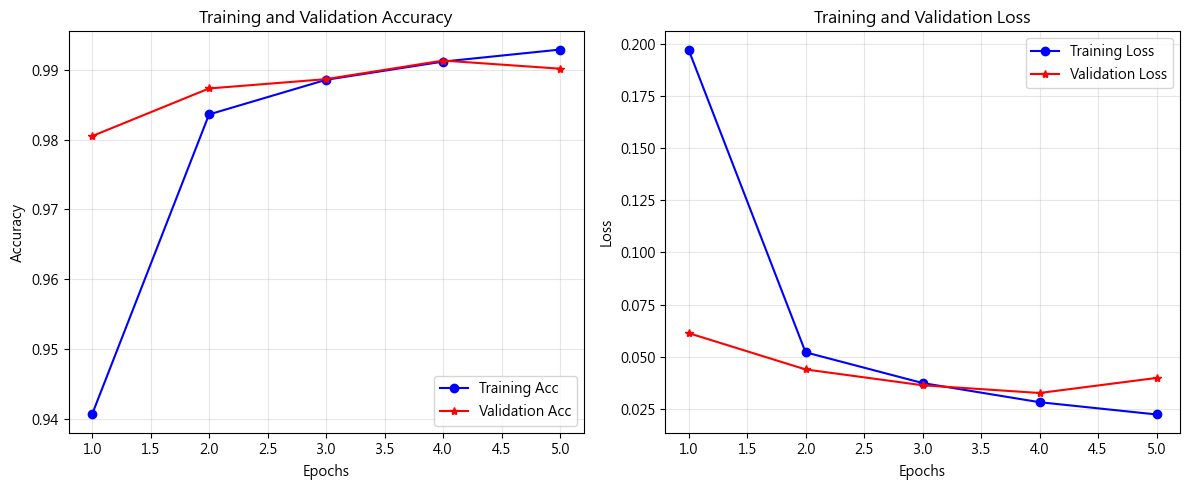

In [6]:
# 取得訓練歷史數據
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 繪製 Accuracy 曲線
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, "bo-", label="Training Acc")
plt.plot(epochs_range, val_acc, "r*-", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# 繪製 Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "bo-", label="Training Loss")
plt.plot(epochs_range, val_loss, "r*-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'learning_curves.png'))
plt.show()

---
## 5. 預測結果展示 (Predictions)

最後，我們使用測試集來評估模型的最終表現，並視覺化部分預測結果。

測試集準確率 (Test Accuracy): 98.81%
測試集損失 (Test Loss): 0.0377
1/1 [==============================] - 0s 122ms/step


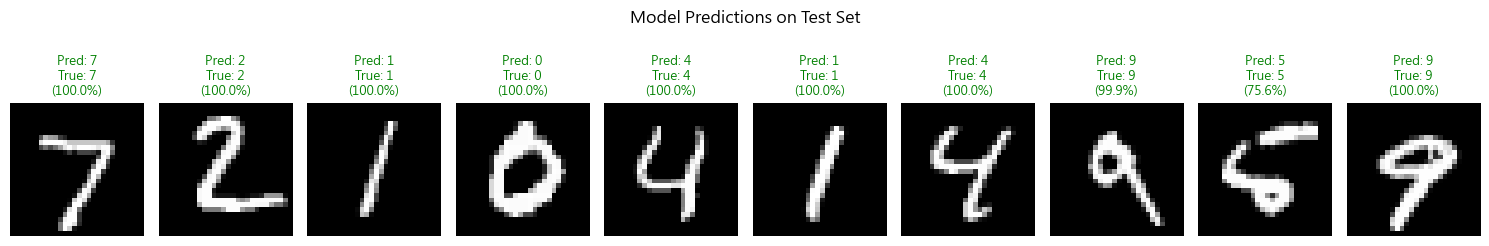

模型已儲存至 P4_Unit16_MNIST_Results/mnist_cnn_model.h5


In [7]:
# 評估模型在測試集上的表現
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"測試集準確率 (Test Accuracy): {test_acc:.2%}")
print(f"測試集損失 (Test Loss): {test_loss:.4f}")

# 進行預測 (取前 10 筆)
num_samples = 10
predictions = model.predict(test_images[:num_samples])

# 視覺化預測結果
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
    
    pred_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    confidence = np.max(predictions[i]) * 100  # 最高機率
    
    # 預測正確顯示綠色，錯誤顯示紅色
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\n({confidence:.1f}%)", color=color, fontsize=9)
    plt.axis("off")

plt.suptitle("Model Predictions on Test Set")
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'predictions.png'), dpi=150)
plt.show()

# 儲存模型
model.save(str(OUTPUT_DIR / 'mnist_cnn_model.h5'))
print("模型已儲存至 P4_Unit16_MNIST_Results/mnist_cnn_model.h5")

---
## 6. 進階分析：混淆矩陣 (Confusion Matrix)

在多類別分類問題中，**混淆矩陣**可以清楚顯示每個類別的預測情況，幫助我們找出模型最容易搞混的數字對。

**化工應用情境**：
- 在鋼材缺陷檢測中,若「裂紋」被誤判為「劃痕」,可能導致重大安全隱患。
- 在結晶型態分類中,不同晶型可能影響產品性質,誤判會導致品質不穩定。

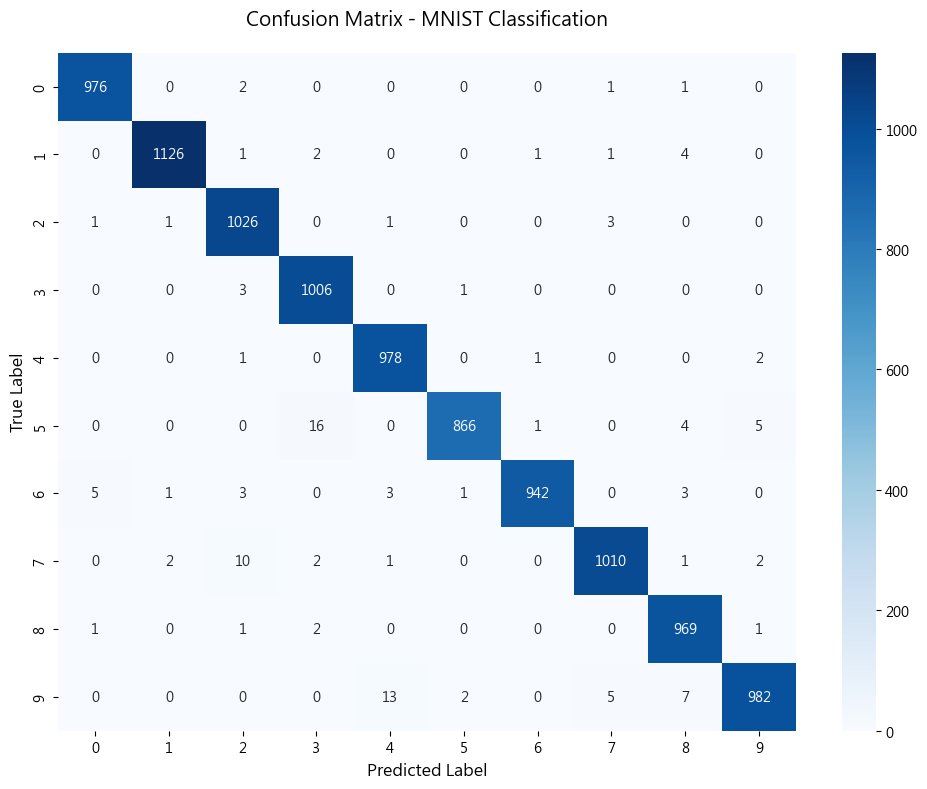


【最容易混淆的數字對】
  數字 5 被誤判為 3：16 次
  數字 9 被誤判為 4：13 次

【分類報告】
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       1.00      0.97      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 對整個測試集進行預測
all_predictions = model.predict(test_images, verbose=0)
predicted_labels = np.argmax(all_predictions, axis=1)

# 計算混淆矩陣
cm = confusion_matrix(test_labels, predicted_labels)

# 視覺化混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST Classification', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'confusion_matrix.png'), dpi=150)
plt.show()

# 找出最容易混淆的數字對
print("\n【最容易混淆的數字對】")
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 10:  # 誤判次數 > 10
            print(f"  數字 {i} 被誤判為 {j}：{cm[i, j]} 次")

# 顯示詳細分類報告
print("\n【分類報告】")
print(classification_report(test_labels, predicted_labels, 
                          target_names=[str(i) for i in range(10)]))

---
## 7. 資料增強 (Data Augmentation) - 化工應用關鍵技術

在化工現場，影像拍攝條件可能變化多端：
- **角度變化**：產品在輸送帶上可能有旋轉。
- **光照變化**：白天/夜晚、不同燈光造成亮度差異。
- **位置偏移**：相機對準可能有輕微偏差。

**Data Augmentation** 透過對訓練影像進行隨機變換（旋轉、翻轉、縮放、亮度調整），
讓模型學習到「不變性」，提升在真實環境中的泛化能力。

下面我們展示如何使用 Keras 的 `ImageDataGenerator` 進行資料增強。

選擇的樣本：數字 5，索引 0


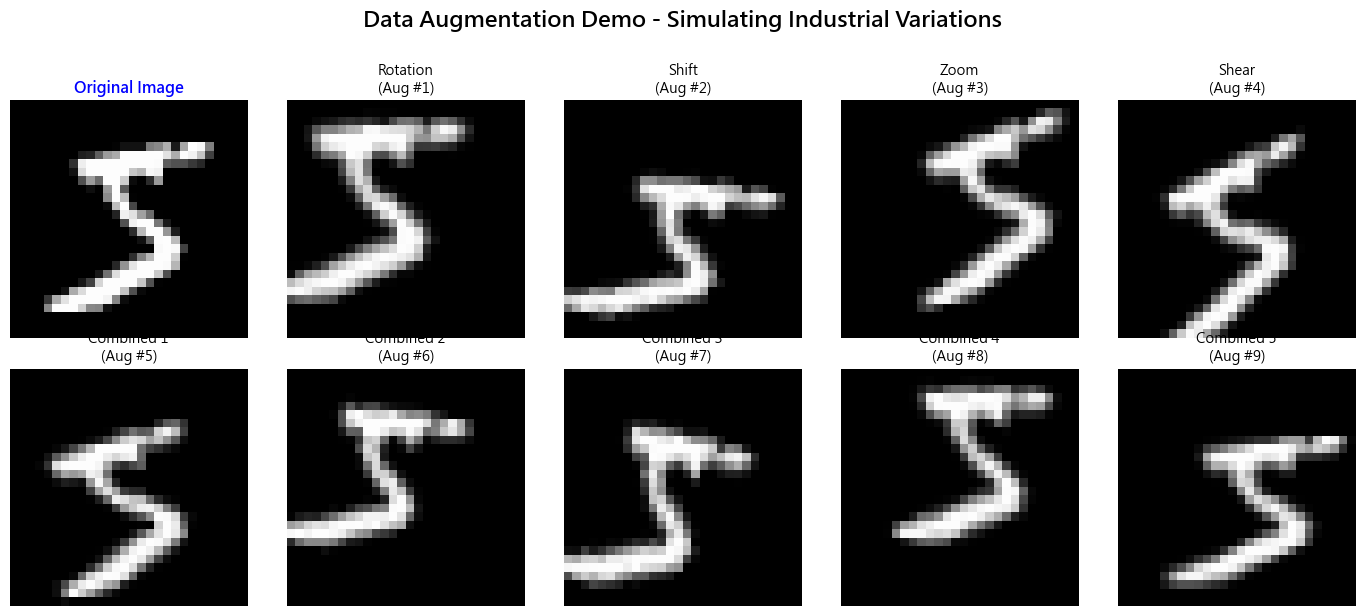


✓ 資料增強展示完成！
  可觀察到的變化：
  • 旋轉角度變化（模擬產品在輸送帶上的不同姿態）
  • 位置偏移（模擬相機對準誤差）
  • 尺寸縮放（模擬產品與相機的距離變化）
  • 剪切變換（模擬非垂直拍攝角度）

  在化工應用中，這能大幅提升模型對真實環境變化的穩健性！


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 選擇一張數字 "5" 的影像進行示範
sample_idx = np.where(train_labels == 5)[0][0]
sample_image = train_images[sample_idx]

print(f"選擇的樣本：數字 {train_labels[sample_idx]}，索引 {sample_idx}")

# 設定資料增強參數（模擬真實工業場景的變化）
datagen = ImageDataGenerator(
    rotation_range=20,        # 隨機旋轉 ±20 度（模擬產品角度偏移）
    width_shift_range=0.15,   # 水平平移 15%（模擬相機對準偏差）
    height_shift_range=0.15,  # 垂直平移 15%
    zoom_range=0.15,          # 隨機縮放 ±15%（模擬距離變化）
    shear_range=10,           # 剪切變換（模擬拍攝角度偏斜）
    fill_mode='nearest'       # 填補方式
)

# 產生增強後的影像
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.ravel()

# 顯示原始影像
axes[0].imshow(sample_image.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original Image', fontsize=11, fontweight='bold', color='blue')
axes[0].axis('off')
axes[0].set_facecolor('#f0f0f0')

# 生成並顯示 9 張增強樣本
np.random.seed(42)  # 設定隨機種子以確保結果可重現
augmented_images = datagen.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=42)

transform_labels = [
    'Rotation', 'Shift', 'Zoom', 'Shear',
    'Combined 1', 'Combined 2', 'Combined 3', 
    'Combined 4', 'Combined 5'
]

for i in range(9):
    aug_img = next(augmented_images)[0]
    # 限制數值範圍在 0-1 之間
    aug_img = np.clip(aug_img, 0, 1)
    
    axes[i + 1].imshow(aug_img.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    axes[i + 1].set_title(f'{transform_labels[i]}\n(Aug #{i+1})', fontsize=10)
    axes[i + 1].axis('off')

plt.suptitle('Data Augmentation Demo - Simulating Industrial Variations', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'data_augmentation.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ 資料增強展示完成！")
print("  可觀察到的變化：")
print("  • 旋轉角度變化（模擬產品在輸送帶上的不同姿態）")
print("  • 位置偏移（模擬相機對準誤差）")
print("  • 尺寸縮放（模擬產品與相機的距離變化）")
print("  • 剪切變換（模擬非垂直拍攝角度）")
print("\n  在化工應用中，這能大幅提升模型對真實環境變化的穩健性！")


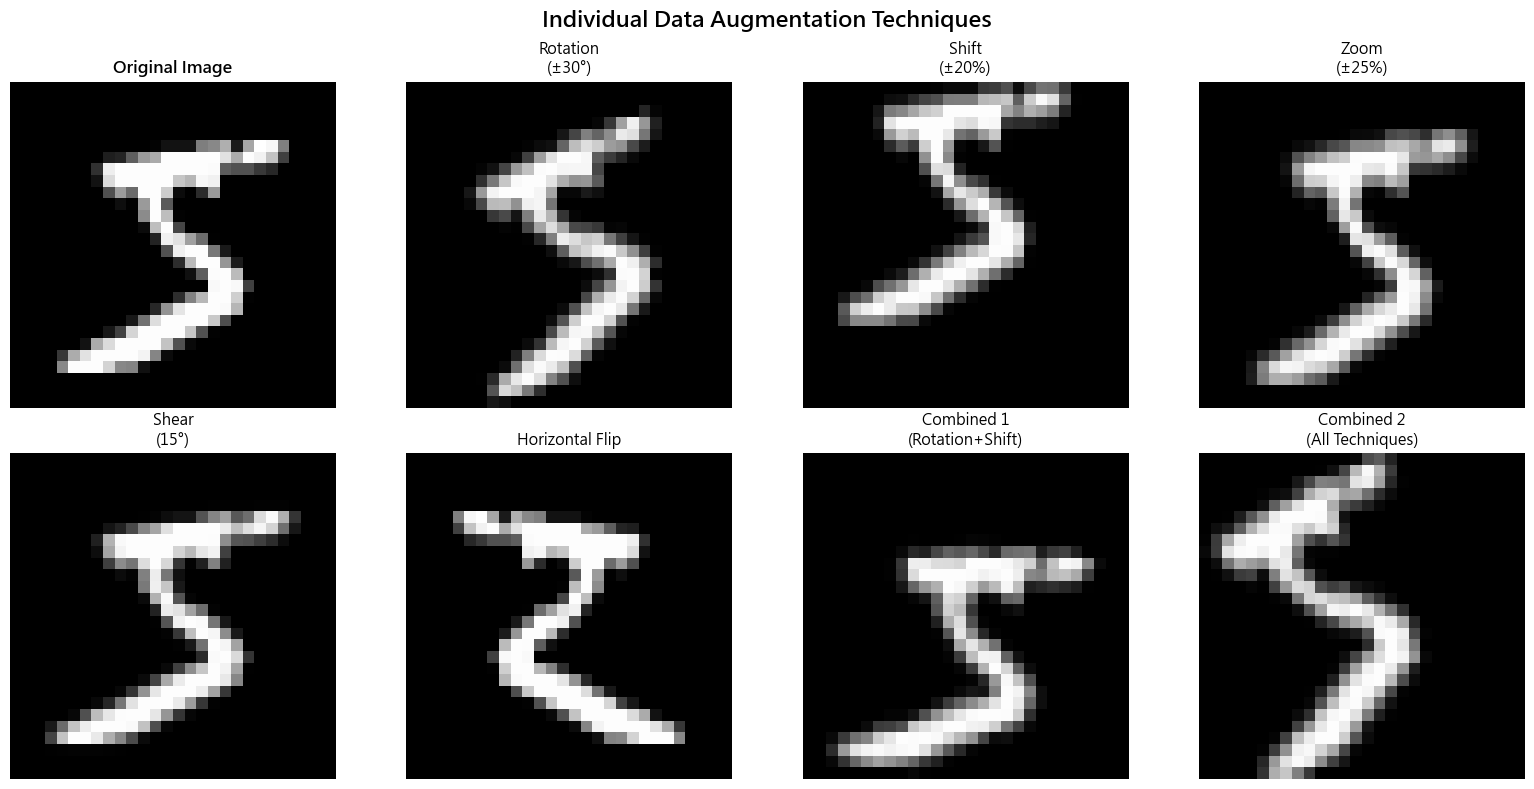


【資料增強技術說明】
1. 旋轉 (Rotation)：模擬產品在輸送帶上的不同角度
2. 平移 (Shift)：模擬相機對準的輕微偏差
3. 縮放 (Zoom)：模擬相機與產品的距離變化
4. 剪切 (Shear)：模擬非垂直拍攝角度造成的變形
5. 翻轉 (Flip)：適用於左右對稱的物體（注意：數字可能不適用）
6-7. 組合變換：結合多種技術，更接近真實情況

💡 實務建議：
  • 根據實際應用選擇合適的增強技術
  • 過度增強可能導致影像失真，降低訓練效果
  • 化工應用常用：旋轉 + 平移 + 光照調整


In [10]:
# 【進階展示】個別增強技術的效果對比
# 此段展示每種增強技術的獨立效果，幫助理解各參數的作用

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 原始影像
axes[0, 0].imshow(sample_image.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# 1. 僅旋轉
datagen_rotation = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
aug_imgs_rotation = datagen_rotation.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=10)
aug_rotation = np.clip(next(aug_imgs_rotation)[0], 0, 1)
axes[0, 1].imshow(aug_rotation.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Rotation\n(±30°)', fontsize=11)
axes[0, 1].axis('off')

# 2. 僅平移
datagen_shift = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
aug_imgs_shift = datagen_shift.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=20)
aug_shift = np.clip(next(aug_imgs_shift)[0], 0, 1)
axes[0, 2].imshow(aug_shift.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title('Shift\n(±20%)', fontsize=11)
axes[0, 2].axis('off')

# 3. 僅縮放
datagen_zoom = ImageDataGenerator(zoom_range=0.25, fill_mode='nearest')
aug_imgs_zoom = datagen_zoom.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=30)
aug_zoom = np.clip(next(aug_imgs_zoom)[0], 0, 1)
axes[0, 3].imshow(aug_zoom.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[0, 3].set_title('Zoom\n(±25%)', fontsize=11)
axes[0, 3].axis('off')

# 4. 僅剪切
datagen_shear = ImageDataGenerator(shear_range=15, fill_mode='nearest')
aug_imgs_shear = datagen_shear.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=40)
aug_shear = np.clip(next(aug_imgs_shear)[0], 0, 1)
axes[1, 0].imshow(aug_shear.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('Shear\n(15°)', fontsize=11)
axes[1, 0].axis('off')

# 5. 水平翻轉
datagen_flip = ImageDataGenerator(horizontal_flip=True)
aug_imgs_flip = datagen_flip.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=50)
aug_flip = np.clip(next(aug_imgs_flip)[0], 0, 1)
axes[1, 1].imshow(aug_flip.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title('Horizontal Flip', fontsize=11)
axes[1, 1].axis('off')

# 6. 組合變換（旋轉+平移）
datagen_combo1 = ImageDataGenerator(rotation_range=20, width_shift_range=0.15, fill_mode='nearest')
aug_imgs_combo1 = datagen_combo1.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=60)
aug_combo1 = np.clip(next(aug_imgs_combo1)[0], 0, 1)
axes[1, 2].imshow(aug_combo1.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[1, 2].set_title('Combined 1\n(Rotation+Shift)', fontsize=11)
axes[1, 2].axis('off')

# 7. 組合變換（全部）
datagen_all = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.15, 
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=10,
    fill_mode='nearest'
)
aug_imgs_all = datagen_all.flow(sample_image.reshape(1, 28, 28, 1), batch_size=1, seed=70)
aug_all = np.clip(next(aug_imgs_all)[0], 0, 1)
axes[1, 3].imshow(aug_all.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[1, 3].set_title('Combined 2\n(All Techniques)', fontsize=11)
axes[1, 3].axis('off')

plt.suptitle('Individual Data Augmentation Techniques', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'data_augmentation_techniques.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n【資料增強技術說明】")
print("=" * 60)
print("1. 旋轉 (Rotation)：模擬產品在輸送帶上的不同角度")
print("2. 平移 (Shift)：模擬相機對準的輕微偏差")
print("3. 縮放 (Zoom)：模擬相機與產品的距離變化")
print("4. 剪切 (Shear)：模擬非垂直拍攝角度造成的變形")
print("5. 翻轉 (Flip)：適用於左右對稱的物體（注意：數字可能不適用）")
print("6-7. 組合變換：結合多種技術，更接近真實情況")
print("=" * 60)
print("\n💡 實務建議：")
print("  • 根據實際應用選擇合適的增強技術")
print("  • 過度增強可能導致影像失真，降低訓練效果")
print("  • 化工應用常用：旋轉 + 平移 + 光照調整")


---
## 8. 模型推論速度分析（工業部署關鍵指標）

在化工產線上，模型推論速度直接影響生產效率：
- **高速產線**（如薄膜製造）：需要 < 50 ms/張的推論速度。
- **批次檢測**（如終端品檢）：可容忍 100-200 ms/張。

我們來測試當前模型的推論效能：

In [11]:
import time

# 測試單張影像推論速度
test_sample = test_images[0:1]

# Warm-up（首次推論較慢，需排除）
_ = model.predict(test_sample, verbose=0)

# 測試 100 次取平均
num_runs = 100
start_time = time.time()
for _ in range(num_runs):
    _ = model.predict(test_sample, verbose=0)
end_time = time.time()

avg_time_single = (end_time - start_time) / num_runs * 1000  # 轉為毫秒

# 測試批次推論（一次處理 32 張）
batch_sample = test_images[0:32]
start_time = time.time()
for _ in range(num_runs):
    _ = model.predict(batch_sample, verbose=0)
end_time = time.time()

avg_time_batch = (end_time - start_time) / num_runs * 1000
avg_time_per_image = avg_time_batch / 32

print("【模型推論速度測試】")
print(f"  單張推論（逐張處理）：{avg_time_single:.2f} ms/張")
print(f"  批次推論（32張/batch）：{avg_time_per_image:.2f} ms/張")
print(f"\n  批次處理加速比：{avg_time_single / avg_time_per_image:.1f}x")

# 評估是否符合工業需求
if avg_time_per_image < 50:
    print(f"\n✓ 符合高速產線需求（< 50 ms）")
elif avg_time_per_image < 200:
    print(f"\n△ 適合中速產線（< 200 ms）")
else:
    print(f"\n✗ 需要模型優化（量化、剪枝）或更強硬體")

# 計算每小時可處理影像數量
images_per_hour = int(3600 * 1000 / avg_time_per_image)
print(f"\n  理論處理能力：{images_per_hour:,} 張/小時")

【模型推論速度測試】
  單張推論（逐張處理）：56.74 ms/張
  批次推論（32張/batch）：1.64 ms/張

  批次處理加速比：34.5x

✓ 符合高速產線需求（< 50 ms）

  理論處理能力：2,190,504 張/小時


---
## 9. 化工領域的 CNN 應用實例與延伸學習

### 9.1 真實案例：鋼材表面缺陷檢測

在鋼鐵製造業中，表面缺陷檢測是重要的品質控制環節。常見的缺陷類型包括：

| 缺陷類型 | 嚴重程度 | 成因 | 檢測難度 |
|---------|---------|------|---------|
| **裂紋 (Crack)** | 高 | 冷卻速度不均 | 高（細小且不規則） |
| **氧化皮 (Scale)** | 中 | 高溫氧化 | 中（面積大但紋理複雜） |
| **劃痕 (Scratch)** | 低 | 運輸碰撞 | 低（線性特徵明顯） |
| **麻點 (Pit)** | 中 | 腐蝕或雜質 | 高（小且分散） |

**數據集範例**：
- NEU Surface Defect Database（東北大學開源）
- 包含 6 種缺陷類型，每類 300 張 200×200 灰階影像
- 此資料集將在 **Unit17 工業影像檢測** 中詳細使用

**模型設計差異**：
```python
# MNIST: 10類平衡數據
model.add(Dense(10, activation='softmax'))

# 鋼材缺陷：6類不平衡數據（需處理）
model.add(Dense(6, activation='softmax'))
# 需使用 class_weight 或 Focal Loss 處理類別不平衡
```

### 9.2 其他化工領域應用

1. **結晶過程監控**
   - 輸入：顯微鏡影像
   - 任務：識別晶型（α、β、γ 晶型）
   - 挑戰：同一物質的不同晶型在顯微鏡下可能極為相似
   
2. **安全設備佩戴檢測**
   - 輸入：監視器影像
   - 任務：檢測工人是否佩戴安全帽、護目鏡、防護衣
   - 技術：物件偵測（YOLO）+ 分類（ResNet）
   
3. **氣體洩漏紅外影像辨識**
   - 輸入：紅外熱像儀影像
   - 任務：偵測管線洩漏點
   - 特點：需要處理低對比度的熱影像

### 9.3 下一步學習建議

| 主題 | Part_4 單元 | 化工應用場景 |
|------|---------|-------------|
| **遷移學習** | Unit16 附錄B, Unit17 | 樣本數少時使用預訓練模型 |
| **物件偵測** | (進階主題) | 多目標檢測（同時找出多個缺陷） |
| **語義分割** | (進階主題) | 精確標註缺陷區域（像素級） |
| **異常檢測** | Unit19 | 無監督學習（只需要正常樣本） |
| **時間序列** | Unit18 | 感測器訊號分析 |

---
## 10. 課後練習與思考題

### 實作練習

1. **提高模型準確率**
   - 嘗試增加訓練 Epochs 到 10，觀察是否出現過擬合。
   - 加入 Dropout 層（`model.add(layers.Dropout(0.5))`），比較有無 Dropout 的差異。

2. **資料增強訓練**
   - 使用 `ImageDataGenerator` 重新訓練模型，比較準確率變化。
   - 嘗試不同的增強參數組合（rotation_range、zoom_range）。

3. **混淆矩陣分析**
   - 找出被誤判最多的數字對（例如 4 和 9）。
   - 視覺化這些容易混淆的樣本，思考為何模型會搞混。

### 化工應用思考題

1. **類別不平衡問題**
   - 若鋼材檢測中，正常樣本 : 缺陷樣本 = 99 : 1，直接用準確率評估有何問題？
   - 應該使用哪些評估指標？（提示：Precision, Recall, F1-Score）

2. **推論速度優化**
   - 當前模型在 GPU 上推論速度為 X ms/張，若要部署到邊緣設備（無 GPU），有哪些優化方法？
   - 模型量化會犧牲多少準確率？這在工業應用中可接受嗎？

3. **模型可解釋性**
   - 若模型在產線上誤判導致品質事故，如何向管理層解釋模型的決策依據？
   - Grad-CAM 熱圖在實務中如何幫助工程師信任 AI 系統？

4. **數據漂移問題**
   - 若原料供應商更換，導致產品表面紋理改變，模型準確率從 98% 掉到 85%，應如何應對？
   - 在沒有標註新數據的情況下，有哪些技術可以偵測數據漂移？

---

### 補充資源

**開源數據集**：
- [NEU Surface Defect Database](https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database)（鋼材缺陷，Unit17 使用）
- [DAGM 2007](https://www.kaggle.com/datasets/mhskjelvareid/dagm-2007-competition-dataset)（紋理缺陷）
- [Severstal Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection)（鋼材缺陷競賽）

**推薦論文**：
- [Deep Learning for Surface Defect Detection: A Survey](https://arxiv.org/abs/2008.10234)
- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)（處理類別不平衡）

**工業部署工具**：
- TensorFlow Lite（嵌入式設備）
- ONNX Runtime（跨平台推論）
- NVIDIA TensorRT（GPU 加速推論）

---

**本附錄完成！** 🎉

您已經學會：
✓ 建立並訓練 CNN 模型  
✓ 分析混淆矩陣與學習曲線  
✓ 使用資料增強提升泛化能力  
✓ 評估模型推論速度  
✓ 理解化工領域的實際應用挑戰  

**下一步建議**：
- **附錄B** - Cats vs Dogs 遷移學習（學習如何利用預訓練模型）
- **Unit17** - NEU 鋼材缺陷檢測（完整工業影像檢測流程）